# Predictive Analytics for Product Segmentation in the Retail Market Using Deep Learning

Segmentation is a method used to identify and meet the needs of specific customer groups with similar requirements within a market. Product segmentation allows companies to spread the risk of selling high-cost products across multiple target markets. Rather than relying on one product, one market, and a single supply-and-demand curve—essentially "putting all the eggs in one basket"—manufacturers can sell variations of the product at different prices to different market segments.

This notebook presents an analysis of one year of data (from 2010/12/01 to 2011/12/09) from an online retail store (E-commerce database) using Deep Learning in Python with TensorFlow and Keras. The dataset, available at UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Online+Retail), is used to predict the category of products customers are likely to purchase based on various parameters.

In [1]:
# Lets start by importing libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, warnings
warnings.filterwarnings("ignore")
from IPython.display import display, HTML
from sklearn import preprocessing, model_selection, metrics, feature_selection
%matplotlib inline

In [2]:
df_read = pd.read_excel('Online Retail.xlsx', dtype={'CustomerID': str,'InvoiceNo': str})

Save a copy

In [3]:
df_initial= df_read
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


We have a dataset with half a million entries, but to manage computational costs, we've selected a random subset of 1,00,000 entries to work with.

In [4]:
np.random.seed(1)
df_initial = df_initial.sample(frac=1).reset_index(drop=True)

In [5]:
df_initial= df_initial[:100000]

Now lets print the null value indices

In [6]:
# Info on columns types and numer of null values
tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column dtype'})
tab_info = pd.concat([tab_info, pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values'})])
tab_info = pd.concat([tab_info, pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0] * 100).T
                      .rename(index={0: 'null values (%)'})])

display(tab_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column dtype,object,object,object,int64,datetime64[ns],float64,object,object
null values,0,0,265,0,0,0,24988,0
null values (%),0.0,0.0,0.265,0.0,0.0,0.0,24.988,0.0


Dropping null values

In [7]:
df_initial.dropna(axis = 0,inplace = True)
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75012 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    75012 non-null  object        
 1   StockCode    75012 non-null  object        
 2   Description  75012 non-null  object        
 3   Quantity     75012 non-null  int64         
 4   InvoiceDate  75012 non-null  datetime64[ns]
 5   UnitPrice    75012 non-null  float64       
 6   CustomerID   75012 non-null  object        
 7   Country      75012 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 5.2+ MB


In [8]:
tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column dtype'})
tab_info = pd.concat([tab_info, pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values'})])
tab_info = pd.concat([tab_info, pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0] * 100).T
                      .rename(index={0: 'null values (%)'})])

display(tab_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column dtype,object,object,object,int64,datetime64[ns],float64,object,object
null values,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, lets deal with duplicates

In [9]:
print('Duplicate entries: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Duplicate entries: 206


In [10]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74806 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    74806 non-null  object        
 1   StockCode    74806 non-null  object        
 2   Description  74806 non-null  object        
 3   Quantity     74806 non-null  int64         
 4   InvoiceDate  74806 non-null  datetime64[ns]
 5   UnitPrice    74806 non-null  float64       
 6   CustomerID   74806 non-null  object        
 7   Country      74806 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 5.1+ MB


## Feature Analysis
Let's dive into the feature analysis. This dataset consists of 8 key variables, described as follows:

InvoiceNo: A nominal 6-digit number uniquely identifying each transaction. If the code starts with 'C', it signifies a cancellation.

StockCode: A nominal 5-digit number representing a unique code for each product.

Description: A nominal field containing the name of each product.

Quantity: A numeric value indicating the number of items purchased per transaction.

InvoiceDate: A numeric field capturing the date and time the transaction occurred.

UnitPrice: A numeric field showing the price per unit of the product in sterling.

CustomerID: A nominal 5-digit number uniquely identifying each customer.

Country: A nominal field specifying the country where the customer resides.

Countries
Here, Lets quickly look at the countries from which orders were made:

In [11]:
temp = df_initial.groupby(['Country'])
countries = temp['Country'].value_counts()
print('No. of countries in dataframe: {}'.format(len(countries)))

No. of countries in dataframe: 37


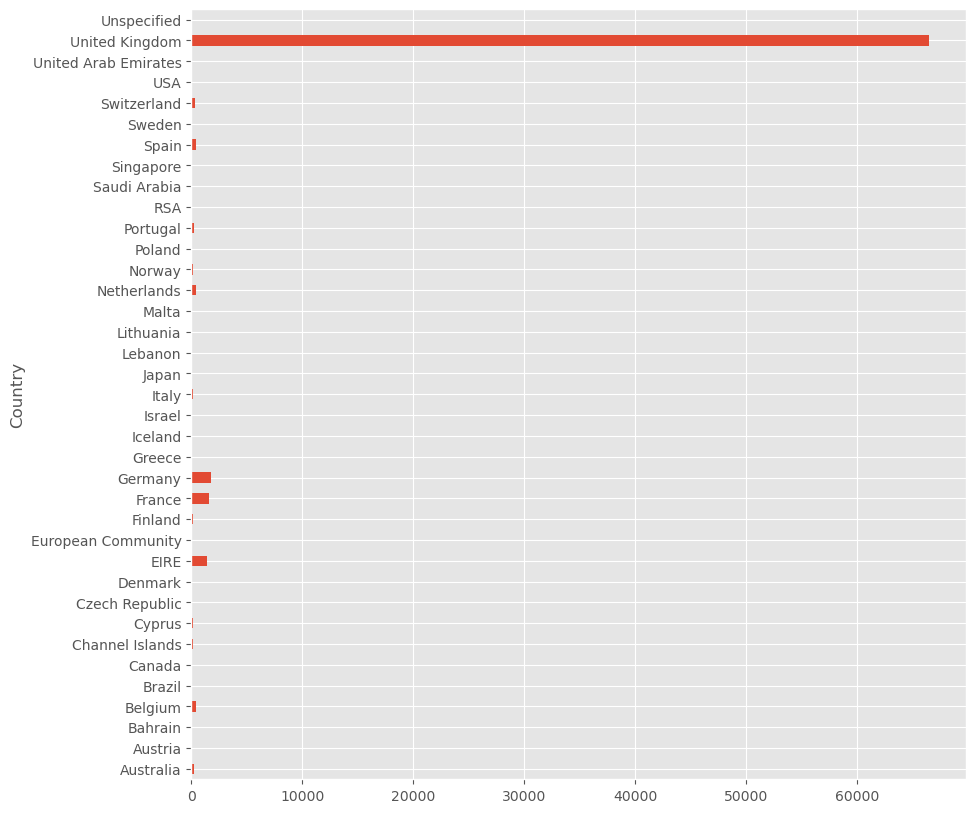

In [12]:
# Plot Countries
plt.style.use('ggplot')
plt.figure(figsize= (10,10))
plt.xlabel('Count')
temp['Country'].value_counts().plot(kind = 'barh', grid = True)
plt.show()

We see that the dataset is largely dominated by orders made from the UK. So lets create two categories UK and Non_UK

In [13]:
Country_n = []
for item in df_initial['Country']:
    if item == 'United Kingdom' :
        Country_n.append('UK')
    else:
        Country_n.append('Non_UK')
df_initial['Country_n'] = Country_n

Customers and orders



In [14]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3266,16352,4078


It can be seen that the data concern 4078 users and that they bought 3266 different products. The total number of transactions carried out is of the order of ∼∼ 16352

Cancelling orders
First of all, count the number of transactions corresponding to canceled orders, indicated by the letter C in InvoiceNo feature.This creates another variable OrderCancelled

In [15]:
OrderCanceled = []
for item in df_initial['InvoiceNo']:
    if 'C' in str(item):
        OrderCanceled.append(1)
    else:
        OrderCanceled.append(0)
df_initial['OrderCancelled'] = OrderCanceled 

In [16]:
(df_initial['OrderCancelled'] == 1).sum()/(df_initial['InvoiceNo'].shape[0])

0.021950110953666817

The number of cancellations is rather small, around 2.2% of total transactions.

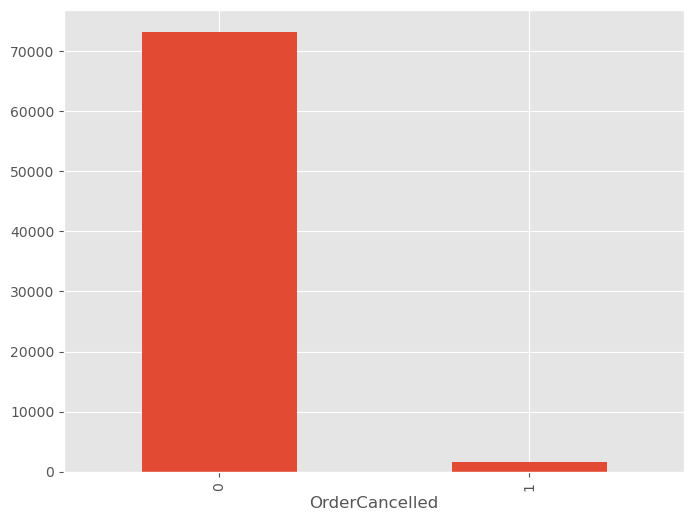

In [17]:
plt.figure(figsize= (8,6))
plt.xlabel('Count')
df_initial['OrderCancelled'].value_counts().plot(kind = 'bar', grid = True)
plt.show()

InvoiceDate variable
Lets extract another variable, Season_month fro the InvoiceDate variable

In [18]:
df_initial['Season_month'] = df_initial['InvoiceDate'].map(lambda x: x.month)
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_n,OrderCancelled,Season_month
0,C544414,22960,JAM MAKING SET WITH JARS,-2,2011-02-18 14:54:00,3.75,13408,United Kingdom,UK,1,2
2,575656,22952,60 CAKE CASES VINTAGE CHRISTMAS,48,2011-11-10 14:29:00,0.55,13319,United Kingdom,UK,0,11
3,571636,20674,GREEN POLKADOT BOWL,16,2011-10-18 11:41:00,1.25,13509,United Kingdom,UK,0,10
4,576657,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-11-16 11:03:00,1.65,12720,Germany,Non_UK,0,11
5,569823,23298,SPOTTY BUNTING,1,2011-10-06 12:15:00,4.95,16895,United Kingdom,UK,0,10


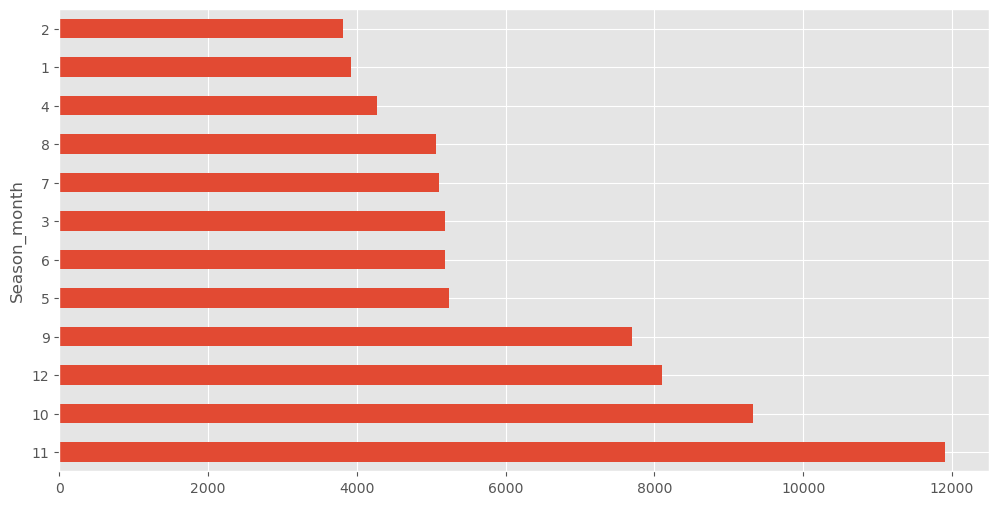

In [19]:
plt.figure(figsize= (12,6))
plt.xlabel('Count')
df_initial['Season_month'].value_counts().plot(kind = 'barh', grid = True)
plt.show()

Lets create 4 Quarter categories and put them in the variable Quarter_y

In [20]:
Quarter = []
for item in df_initial['Season_month']:
    if item < 4 :
        Quarter.append('Q1')
    elif item < 7:
        Quarter.append('Q2')
    elif item < 10:
        Quarter.append('Q3')
    else:
        Quarter.append('Q4')

In [21]:
df_initial['Quarter_y'] = Quarter


Creating Product Category variable
Lets use the StockCode variable to create four product categories, counting the volume of sales.

In [22]:
Counts = df_initial['StockCode'].value_counts().to_dict()


In [23]:
Categ1 = [];Categ2 = [];Categ3 = [];Categ4 = []
for key,value in Counts.items():
    if value < 25:
        Categ4.append(str(key))
    elif value <= 50:
        Categ3.append(str(key))
    elif value <= 200:
        Categ2.append(str(key))
    else :
        Categ1.append(str(key))

In [24]:
Product_Categ = []
for item in df_initial['StockCode']: 
    if item in Categ1:
        Product_Categ.append(0)
    elif item in Categ2:
        Product_Categ.append(1)
    elif item in Categ3:
        Product_Categ.append(2)
    else:
        Product_Categ.append(3)

In [25]:
len(Product_Categ)


74806

In [26]:
# adding the variable to the DataFrame.
df_initial['Prod_Categ'] = Product_Categ

In [27]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_n,OrderCancelled,Season_month,Quarter_y,Prod_Categ
0,C544414,22960,JAM MAKING SET WITH JARS,-2,2011-02-18 14:54:00,3.75,13408,United Kingdom,UK,1,2,Q1,3
2,575656,22952,60 CAKE CASES VINTAGE CHRISTMAS,48,2011-11-10 14:29:00,0.55,13319,United Kingdom,UK,0,11,Q4,3
3,571636,20674,GREEN POLKADOT BOWL,16,2011-10-18 11:41:00,1.25,13509,United Kingdom,UK,0,10,Q4,3
4,576657,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-11-16 11:03:00,1.65,12720,Germany,Non_UK,0,11,Q4,3
5,569823,23298,SPOTTY BUNTING,1,2011-10-06 12:15:00,4.95,16895,United Kingdom,UK,0,10,Q4,3


Numerical variables
We have two numerical variables, Quantity and UnitPrice

(-5000.0, 5000.0)

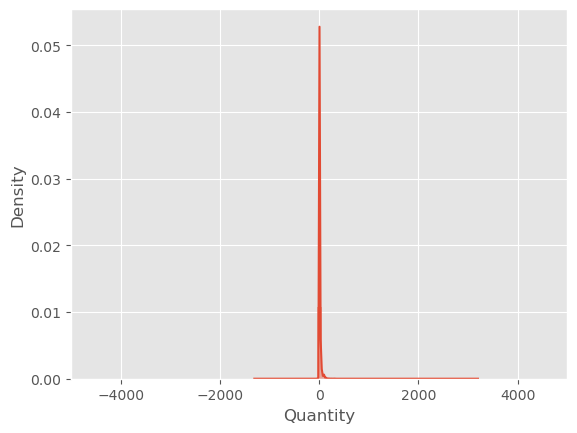

In [28]:
sns.distplot(df_initial["Quantity"])
plt.xlim(-5000,5000)

(0.0, 500.0)

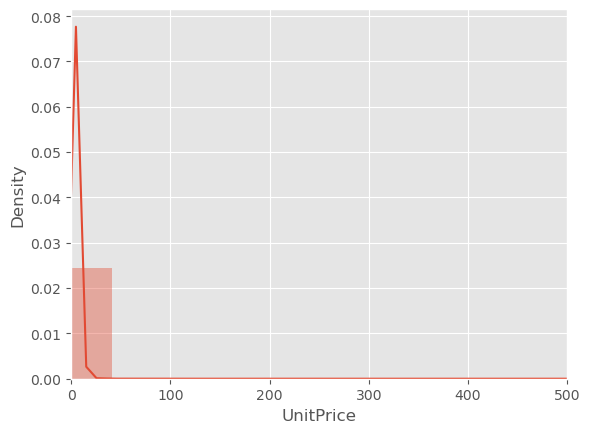

In [29]:
sns.distplot(df_initial["UnitPrice"])
plt.xlim(0,500)

In [30]:
df_initial.info()


<class 'pandas.core.frame.DataFrame'>
Index: 74806 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   InvoiceNo       74806 non-null  object        
 1   StockCode       74806 non-null  object        
 2   Description     74806 non-null  object        
 3   Quantity        74806 non-null  int64         
 4   InvoiceDate     74806 non-null  datetime64[ns]
 5   UnitPrice       74806 non-null  float64       
 6   CustomerID      74806 non-null  object        
 7   Country         74806 non-null  object        
 8   Country_n       74806 non-null  object        
 9   OrderCancelled  74806 non-null  int64         
 10  Season_month    74806 non-null  int64         
 11  Quarter_y       74806 non-null  object        
 12  Prod_Categ      74806 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(7)
memory usage: 8.0+ MB


The data is ready, we can now create x and y variables

In [31]:
X = df_initial.drop(['InvoiceNo','StockCode','Description','InvoiceDate','CustomerID','Country','Season_month','Prod_Categ'], axis = 1)
y = df_initial['Prod_Categ']

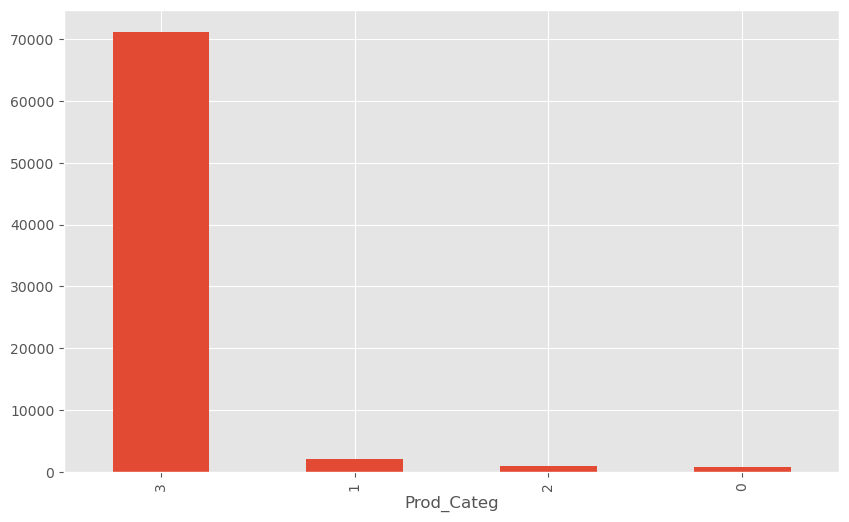

In [32]:
plt.figure(figsize= (10,6))
plt.xlabel('Count')
y.value_counts().plot(kind = 'bar', grid = True)
plt.show()

Due to the high skewness of the output variable, normalization might be beneficial in the training process.

Encoding categorical variables

In [33]:
categorical = ['OrderCancelled','Quarter_y', 'Country_n']
categorical_variables = categorical
X = pd.get_dummies(X, columns = categorical_variables)

In [34]:
#label encoder
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

Feature scaling

In [35]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

creating train and test sets

In [36]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


## Deep Learning
Import TensorFlow and Keras

In [37]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [38]:
# Set logging level for TensorFlow 2.x
tf.get_logger().setLevel('INFO')

In [39]:
# Function to encode labels for neural network
def encode_neural_net_y(y):
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_y = encoder.transform(y)
    new_y = to_categorical(encoded_y)  # Use `to_categorical` from tensorflow.keras.utils
    return new_y

In [40]:
# Encoding y_train and y_test
y_train = encode_neural_net_y(y_train)
y_test = encode_neural_net_y(y_test)

In [41]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (59844, 10)
Shape of y_train:  (59844, 4)
Shape of X_test:  (14962, 10)
Shape of y_test:  (14962, 4)


In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization

# create model
model = Sequential()
model.add(Dense(35, input_dim=10, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

The layers are constructed using keras.layers. A 2-layer fully connected neural network is built, with 35 neurons in the hidden layer.

A batch normalization layer is added between the hidden and output layers to address potential skewness in the data.

The loss function used is categorical_crossentropy, and the optimizer chosen is ADAM. The activation function for the input layers is ReLU, while the output layer uses softmax.

In [43]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 35)             │           385 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 35)             │           140 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           144 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669 (2.61 KB)

 Trainable params: 599 (2.34 KB)

 Non-trainable params: 70 (280.00 B)

Training the model to predict the Product Categories from the transaction data

In [44]:
history = model.fit(np.array(X_train), np.array(y_train), epochs=30, batch_size=40, verbose=1)


Epoch 1/30
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step - acc: 0.8730 - loss: 0.5779
Epoch 2/30
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1s 349us/step - acc: 0.9529 - loss: 0.2345
Epoch 3/30
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1s 351us/step - acc: 0.9545 - loss: 0.2277
Epoch 4/30
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1s 362us/step - acc: 0.9542 - loss: 0.2291
Epoch 5/30
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1s 363us/step - acc: 0.9530 - loss: 0.2315
Epoch 6/30
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1s 347us/step - acc: 0.9545 - loss: 0.2272
Epoch 7/30
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1s 347us/step - acc: 0.9535 - loss: 0.2287
Epoch 8/30
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1s 349us/step - acc: 0.9512 - loss: 0.2361
Epoch 9/30
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1s 348us/step - acc: 0.9530 - loss: 0.2318
Epoch 10/30
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1s 367us/step - acc: 0.9539 - loss: 0.2259
Epoch 11/30
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1s 372us/step - acc: 0.9533 - loss: 0.2299
Epoch 12/30
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1s 349us/step - acc:

In [45]:
scores = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print("     TEST SCORE:    ")
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

     TEST SCORE:    
compile_metrics: 95.29%


In [46]:
scores = model.evaluate(np.array(X_train), np.array(y_train), verbose=0)
print("     TRAIN SCORE:    ")
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

     TRAIN SCORE:    
compile_metrics: 95.38%


# Concluding Remarks
The model performs well on both the training and test sets. Feature analysis was conducted, and new features were engineered to improve predictions.

Although the test set accuracy is slightly lower than the training set by a negligible margin, the impact of regularization still requires further investigation.

An additional approach to feature engineering could involve extracting product information from the Description variable using Natural Language Processing (NLP) tools such as NLTK.